# Experiments With SOM Networks
## Red Wine Quality Dataset

Test different combinations of learning rates and sigma value (size of neighborhood).

All tests are going to use the gaussian neighborhood with a random seed of 5 to initialize the weights.

To show the results, the best resulting network will be choosen.

## Imports

In [6]:
from minisom import MiniSom
from sklearn import datasets
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Functions

In [38]:
# Model building

## Create the model reference using the choosen parameters
def create_model(size, input_dim, sigma=1.0, learning_rate=1.0, nf="gaussian", random_seed=5):
    return MiniSom(size, size, input_dim, sigma=sigma, learning_rate=learning_rate, 
                   neighborhood_function=nf, random_seed=random_seed)

## Create multiple models based of a list of parameters (dicts)
## Returns a list of dicts containing the parameters and the model reference
def create_bundle_of_models(model_parameters):
    return [
        {**{"model": create_model(**model_parameter)}, **model_parameter}
        for model_parameter in model_parameters
    ]

## Creates all of the possible combinations of parameters between two lists
def create_permutations(list_of_data_1, list_of_data_2):
    return list(itertools.product(list_of_data_1, list_of_data_2))

## Creates a list of dicts containing the parameters desired, using the permutation function
def create_test_parameters(sigma_list, learning_rate_list):
    return [
        {"sigma": parameter[0], "learning_rate": parameter[1]}
        for parameter in create_permutations(sigma_list, learning_rate_list)
    ]

# Data manipulation

## Rescale the data between 0 and 1: Xr = X - X_min/(X_max - X_min)
def normalize_data(data):
    max_value = np.max(data)
    min_value = np.min(data)
    return (data - min_value) / (max_value - min_value)

# Plots

## Plot the u-matrix with the target classes on each winner neuron
def plot_u_matrix(model):
    plt.figure(figsize=(10, 10))
    plt.pcolor(model['model'].distance_map().T, cmap='coolwarm')
    plt.colorbar()    

    markers = ['', '', '', '', 'o', 'v', 's', 'D', 'p', 'P']
    colors = ['', '', '', '','C1', 'C2', 'C3', 'C4', 'C5', 'C6']
    for idx, data in enumerate(input_data):
        # Plot only 6 features
        if target[idx] > 5:
            winner = model['model'].winner(data)
            plt.plot(winner[0]+.5, winner[1]+.5, markers[target[idx]], markerfacecolor='None',
                     markeredgecolor=colors[target[idx]], markersize=12, markeredgewidth=2)
    plt.axis([0, 30, 0, 30])
    plt.show()
    
def plot_hit_map(model):
    plt.figure(figsize=(10, 10))
    plt.pcolor(model['model'].activation_response(input_data), cmap='Reds')
    plt.colorbar() 

## The Dataset

In [18]:
### Input variables (based on physicochemical tests):
#    1 - fixed acidity
#    2 - volatile acidity
#    3 - citric acid
#    4 - residual sugar
#    5 - chlorides
#    6 - free sulfur dioxide
#    7 - total sulfur dioxide
#    8 - density
#    9 - pH
#    10 - sulphates
#    11 - alcohol
#    Output variable (based on sensory data): 
#    12 - quality (score between 0 and 10)
###

wine = pd.read_csv("winequality-red.csv", sep=";")
wine_target = wine[['quality']].copy()
wine_features = wine.drop(['quality'], axis=1)
wine_data = {"data": wine_features.to_numpy(), "target": np.array(wine_target["quality"])}

# Data already in desired format for the MiniSom library (numpy matrix)
# Contains the features on the "data" key and the target classifications on "target" key
print("Number of samples: %s" % (len(wine_data["data"])))
print(wine_data)

Number of samples: 1599
{'data': array([[ 7.4  ,  0.7  ,  0.   , ...,  3.51 ,  0.56 ,  9.4  ],
       [ 7.8  ,  0.88 ,  0.   , ...,  3.2  ,  0.68 ,  9.8  ],
       [ 7.8  ,  0.76 ,  0.04 , ...,  3.26 ,  0.65 ,  9.8  ],
       ...,
       [ 6.3  ,  0.51 ,  0.13 , ...,  3.42 ,  0.75 , 11.   ],
       [ 5.9  ,  0.645,  0.12 , ...,  3.57 ,  0.71 , 10.2  ],
       [ 6.   ,  0.31 ,  0.47 , ...,  3.39 ,  0.66 , 11.   ]]), 'target': array([5, 5, 5, ..., 6, 5, 6])}


In [19]:
# Splitting the data

# Normalized input
input_data = normalize_data(wine_data["data"])

# Target classes
target = wine_data["target"]

## Model parameters and building

In [20]:
sigma_list = [0.01, 0.1, 1.0, 2.0, 5.0, 10.0]
learning_rate_list = [0.01, 0.1, 0.5, 1.0, 2.0]

# Fixed grid of 30x30
size = 30

# Fixed iteration number for all models
iterations = 10000

# Number of features, in this case, 4
input_dim = input_data.shape[1]

models = create_bundle_of_models(
    [
        {**parameters, **{"size": size, "input_dim": input_dim}}
        for parameters in create_test_parameters(sigma_list, learning_rate_list)
    ]
)

## Train the models and capture topographic and quantization errors (for ranking)

In [21]:
for model in models:
    # Training using random samples each iteration
    model["model"].train_batch(input_data, iterations)
    model["topographic_error"] = model["model"].topographic_error(input_data)
    model["quantization_error"] = model["model"].quantization_error(input_data)

## Ranking the best models

In [22]:
ranked_models = sorted(models, key = lambda x: (x["topographic_error"], x["quantization_error"]))
best_model = ranked_models[0]
ranked_models

[{'model': <minisom.MiniSom at 0x7f1c7e895d68>,
  'sigma': 1.0,
  'learning_rate': 0.1,
  'size': 30,
  'input_dim': 11,
  'topographic_error': 0.0300187617260788,
  'quantization_error': 0.009532546238056362},
 {'model': <minisom.MiniSom at 0x7f1c7e895f28>,
  'sigma': 5.0,
  'learning_rate': 0.1,
  'size': 30,
  'input_dim': 11,
  'topographic_error': 0.03377110694183865,
  'quantization_error': 0.010466892307754848},
 {'model': <minisom.MiniSom at 0x7f1c7e8a20f0>,
  'sigma': 10.0,
  'learning_rate': 1.0,
  'size': 30,
  'input_dim': 11,
  'topographic_error': 0.03689806128830519,
  'quantization_error': 0.02361014655869066},
 {'model': <minisom.MiniSom at 0x7f1c7e8a2080>,
  'sigma': 10.0,
  'learning_rate': 0.1,
  'size': 30,
  'input_dim': 11,
  'topographic_error': 0.0375234521575985,
  'quantization_error': 0.017121050809451747},
 {'model': <minisom.MiniSom at 0x7f1c7e895c88>,
  'sigma': 2.0,
  'learning_rate': 0.1,
  'size': 30,
  'input_dim': 11,
  'topographic_error': 0.0381488

## Data visualization

### U-Matrix

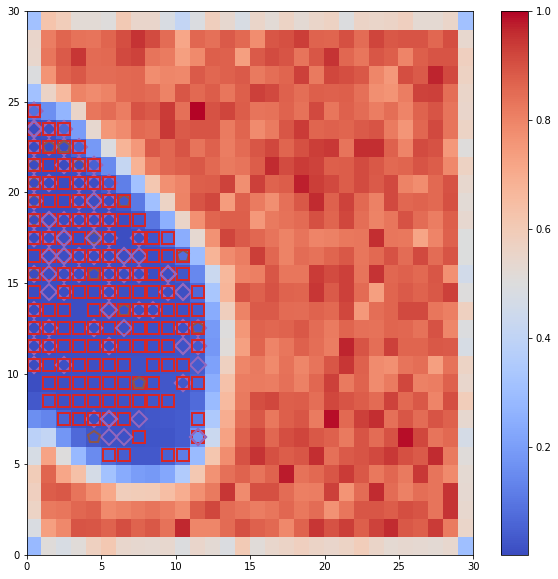

In [39]:
# Rank 1 model

plot_u_matrix(best_model)

### Heat Maps

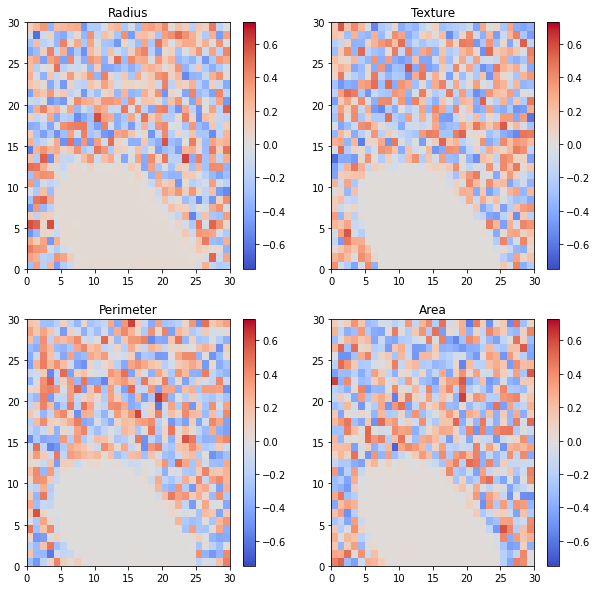

In [40]:
# Rank 1 model

def get_weights(weights, feature_idx):
    feature_weights = []
    for neuron in weights:
        data = []
        for weight in neuron:
            data.append(weight[feature_idx])
        feature_weights.append(list(data))

    return np.array(feature_weights)

def plot_heat_maps(data_1, data_2, data_3, data_4, min_weight, max_weight):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))

    cm = axs[0, 0].pcolor(data_1, cmap='coolwarm', vmin=min_weight, vmax=max_weight)
    axs[0, 0].set_title('Radius')
    fig.colorbar(cm, ax=axs[0,0])

    cm = axs[0, 1].pcolor(data_2, cmap='coolwarm', vmin=min_weight, vmax=max_weight)
    axs[0, 1].set_title('Texture')
    fig.colorbar(cm, ax=axs[0,1])

    cm = axs[1, 0].pcolor(data_3, cmap='coolwarm', vmin=min_weight, vmax=max_weight)
    axs[1, 0].set_title('Perimeter')
    fig.colorbar(cm, ax=axs[1,0])

    cm = axs[1, 1].pcolor(data_4, cmap='coolwarm', vmin=min_weight, vmax=max_weight)
    axs[1, 1].set_title('Area')
    fig.colorbar(cm, ax=axs[1,1])

    for ax in axs.flat:
        ax.label_outer()
    
weights = best_model['model'].get_weights()

fixed_acidity = get_weights(weights, 0)
volatile_acidity = get_weights(weights, 1)
citric_acid = get_weights(weights, 2)
residual_sugar = get_weights(weights, 3)

min_weight = np.min(weights)
max_weight = np.max(weights)

plot_heat_maps(fixed_acidity, volatile_acidity, citric_acid, residual_sugar, min_weight, max_weight)

### Hit Maps

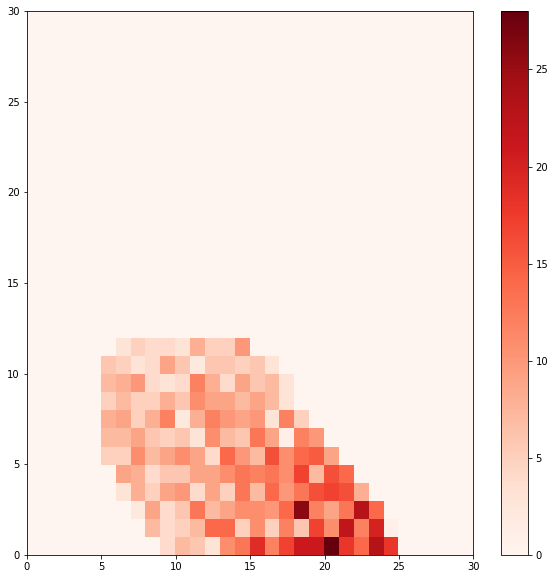

In [41]:
#Rank 1 model
plot_hit_map(best_model)